**Paper Demonstrated** :-[ Perceptual loss for real time style transfer and image superresolution ](http://svl.stanford.edu/assets/papers/JohnsonECCV16.pdf)


Part of the code and test images taken from pytorch example modules

In [0]:
!git clone 'https://github.com/pytorch/examples.git'

Cloning into 'examples'...
remote: Enumerating objects: 2311, done.
remote: Total 2311 (delta 0), reused 0 (delta 0), pack-reused 2311
Receiving objects: 100% (2311/2311), 39.02 MiB | 22.14 MiB/s, done.
Resolving deltas: 100% (1161/1161), done.


In [0]:
!cp -r examples/fast_neural_style/images .
!cp -r examples/fast_neural_style/neural_style/transformer_net.py . 
!cp -r examples/fast_neural_style/neural_style/vgg.py .
!cp -r examples/fast_neural_style/neural_style/utils.py .  
!rm -r examples
!wget https://iso.500px.com/wp-content/uploads/2014/07/mesa-after.jpg

**Downloading the pretrained models**

In [0]:
import os
import zipfile

try:
    from torch.utils.model_zoo import _download_url_to_file
except ImportError:
    from torch.hub import _download_url_to_file
def unzip(source_filename, dest_dir):
    with zipfile.ZipFile(source_filename) as zf:
        zf.extractall(path=dest_dir)
_download_url_to_file('https://www.dropbox.com/s/lrvwfehqdcxoza8/saved_models.zip?dl=1', 'saved_models.zip', None, True)
unzip('saved_models.zip', '.')

/usr/local/lib/python3.6/dist-packages/torch/hub.py:436: UserWarning: torch.hub._download_url_to_file has been renamed to            torch.hub.download_url_to_file to be a public API,            _download_url_to_file will be removed in after 1.3 release
  _download_url_to_file will be removed in after 1.3 release')


**Load the necessary modules**

In [0]:
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

from PIL import Image
import matplotlib.pyplot as plt
import time
import cv2

**Run the following code for visulaization using one of the pretrained styles by pytorch**

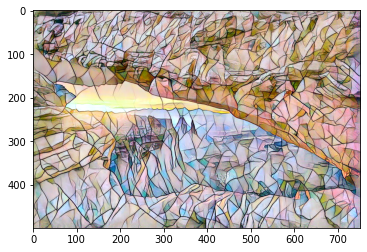

In [0]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
content_img_path='./mesa-after.jpg'
model='./saved_models/mosaic.pth'
content_image=utils.load_image(content_img_path,scale=None)

content_transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.mul(255))])

content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

with torch.no_grad():
  style_model = TransformerNet()
  state_dict = torch.load(model)
  # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
  for k in list(state_dict.keys()):
      if re.search(r'in\d+\.running_(mean|var)$', k):
          del state_dict[k]
  style_model.load_state_dict(state_dict)
  style_model.to(device)
  output = style_model(content_image).cpu()
img=output[0].clone().clamp(0,255).numpy()
img=img.transpose(1,2,0).astype("uint8")
img=Image.fromarray(img)
plt.imshow(img)
img.save('output.jpg')

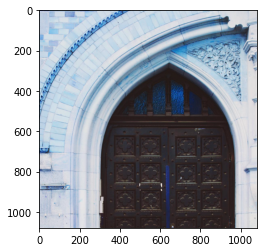

In [0]:
contentimg=cv2.imread('./images/content-images/amber.jpg')
plt.imshow(contentimg)

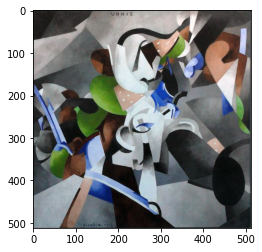

In [0]:
styleimg=cv2.imread('./fast_neural_style/images/style-images/udnie.jpg')
plt.imshow(styleimg)

**Training Loop for trainind the COCO dataset on udnie image**

In [0]:
! wget 'http://images.cocodataset.org/zips/val2017.zip'
os.mkdirs('./train')
!unzip val2017.zip -d train/

--2020-03-27 05:10:09--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.169.123
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.169.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  35.2MB/s    in 23s     

2020-03-27 05:10:32 (34.2 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

Archive:  val2017.zip
checkdir:  cannot create extraction directory: val2017/train
           No such file or directory


In [0]:
nsave_model_dir='./custom_trained'
os.makedirs(save_model_dir)
checkpoint_model_dir='./checkpoint_save'
os.makedirs(checkpoint_model_dir)
image_size=256
dataset='./train'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=4
learning_rate=1e-3
style_size=None
style_image_path='./images/style-images/udnie.jpg'
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

train_dataset = datasets.ImageFolder(dataset, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

transformer = TransformerNet().to(device)
optimizer = Adam(transformer.parameters(), learning_rate)
mse_loss = torch.nn.MSELoss()

vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

style = utils.load_image(style_image_path, size=style_size)
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)

features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

Work Pending Continue from Here

In [0]:
epochs = 2
content_weight = 1e5
style_weight = 1e10
checkpoint_model_dir = 'checkpoint_save'
checkpoint_interval = 2000
log_interval = 500
save_model_dir = 'saved_models'


for e in range(epochs):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()

        x = x.to(device)
        y = transformer(x)

        y = utils.normalize_batch(y)
        x = utils.normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)

        content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight

        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        if (batch_id + 1) % log_interval == 0:
            mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                time.ctime(), e + 1, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)

        if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
            transformer.eval().cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
            ckpt_model_path = os.path.join(checkpoint_model_dir, ckpt_model_filename)
            torch.save(transformer.state_dict(), ckpt_model_path)
            transformer.to(device).train()

# save model
transformer.eval().cpu()
save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
    content_weight) + "_" + str(style_weight) + ".model"
save_model_path = os.path.join(save_model_dir, save_model_filename)
torch.save(transformer.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)


Fri Mar 27 05:21:18 2020	Epoch 1:	[2000/5000]	content: 427132.328281	style: 312305.464453	total: 739437.792734
Fri Mar 27 05:23:47 2020	Epoch 1:	[4000/5000]	content: 365075.352094	style: 230436.954953	total: 595512.307047
Fri Mar 27 05:27:29 2020	Epoch 2:	[2000/5000]	content: 246846.089563	style: 135446.044797	total: 382292.134359
Fri Mar 27 05:29:56 2020	Epoch 2:	[4000/5000]	content: 239316.895469	style: 132802.657742	total: 372119.553211

Done, trained model saved at saved_models/epoch_2_Fri_Mar_27_05:31:10_2020_100000.0_10000000000.0.model


In [0]:
out=transformer(content_image.cpu())
img=out[0].detach().clone().clamp(0,255).numpy()
img=img.transpose(1,2,0).astype("uint8")
img=Image.fromarray(img)
plt.imshow(img)

In [0]:
img.save('ud.jpg')